In [7]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.8/310.8 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.4.0-py2.py3-none-any.whl size=311317130 sha256=de60c24954b76e503cee43b238f4a2aee2776b1148ab734b02e3e3c53bcc9ba7
  Stored in directory: /root/.cache/pip/wheels/7b/1b/4b/3363a1d04368e7ff0d408e57ff57966fcdf00583774e761327
Successfully built pyspark


In [8]:
from pyspark.sql import SparkSession

from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer

from pyspark.ml.regression import LinearRegression

from pyspark.ml.clustering import KMeans

from pyspark.ml.evaluation import RegressionEvaluator, ClusteringEvaluator

from pyspark.ml import Pipeline

import pandas as pd




# Create a SparkSession

spark = SparkSession.builder.getOrCreate()




# Read the data from the CSV file

data = spark.read.csv("combined-data.csv", header=True, inferSchema=True)




# Select the desired columns as features

feature_columns = ["userId", "userSessionId", "teamLevel", "count_gameclicks", "count_hits"]

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

features = assembler.transform(data)




# Convert count_buyId and avg_price columns to numerical types

indexer = StringIndexer(inputCol="count_buyId", outputCol="count_buyId_indexed")

features = indexer.fit(features).transform(features)

indexer = StringIndexer(inputCol="avg_price", outputCol="avg_price_indexed")

features = indexer.fit(features).transform(features)




# Select the target column

target_column = "avg_price_indexed"  # Replace with the actual indexed target column name



# Drop rows with missing values in the target column

features = features.na.drop(subset=[target_column])




# Scale the features

scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

scaler_model = scaler.fit(features)

features = scaler_model.transform(features)




# Split the data into training and test sets

train_data, test_data = features.randomSplit([0.7, 0.3], seed=42)




# Train an SVM regressor

svr = LinearRegression(featuresCol="scaled_features", labelCol=target_column)

svr_model = svr.fit(train_data)




# Make predictions on the test set

predictions_svm = svr_model.transform(test_data)




# Calculate the mean squared error (MSE) of the SVM model

evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="mse")

mse_svm = evaluator.evaluate(predictions_svm)

print("MSE (SVM):", mse_svm)




# Train a K-means clustering model

K = 5  # Replace with the desired number of clusters


kmeans = KMeans(featuresCol="scaled_features", k=K, seed=42)

kmeans_model = kmeans.fit(features)




# Assign cluster labels to the data points

predictions_kmeans = kmeans_model.transform(features)




# Calculate the silhouette score of the K-means model

evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="scaled_features", metricName="silhouette")

silhouette_score_kmeans = evaluator.evaluate(predictions_kmeans)

print("Silhouette Score (K-means):", silhouette_score_kmeans)

MSE (SVM): 38.06371113330674
Silhouette Score (K-means): 0.4683428375220332


In [10]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline

# Create a SparkSession
spark = SparkSession.builder.getOrCreate()

# Read the data from the CSV file
data = spark.read.csv("combined-data.csv", header=True, inferSchema=True)

# Select the desired columns as features
feature_columns = ["userId", "userSessionId", "teamLevel", "count_gameclicks", "count_hits"]
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
features = assembler.transform(data)

# Convert count_buyId and avg_price columns to numerical types
indexer = StringIndexer(inputCol="count_buyId", outputCol="count_buyId_indexed")
features = indexer.fit(features).transform(features)
indexer = StringIndexer(inputCol="avg_price", outputCol="avg_price_indexed")
features = indexer.fit(features).transform(features)

# Select the target column
target_column = "avg_price_indexed"

# Drop rows with missing values in the target column
features = features.na.drop(subset=[target_column])

# Scale the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(features)
features = scaler_model.transform(features)

# Split the data into training and test sets
train_data, test_data = features.randomSplit([0.7, 0.3], seed=42)

# Train a hierarchical clustering model
K = 5  # Replace with the desired number of clusters
hierarchical_clusterer = BisectingKMeans(featuresCol="scaled_features", k=K, seed=42)
hierarchical_model = hierarchical_clusterer.fit(train_data)

# Assign cluster labels to the data points
predictions_hierarchical = hierarchical_model.transform(features)

# Calculate the silhouette score of the hierarchical clustering model
evaluator = ClusteringEvaluator(predictionCol="prediction", featuresCol="scaled_features", metricName="silhouette")
silhouette_score_hierarchical = evaluator.evaluate(predictions_hierarchical)

print("Silhouette Score (Hierarchical Clustering):", silhouette_score_hierarchical)

Silhouette Score (Hierarchical Clustering): 0.39391358666500675


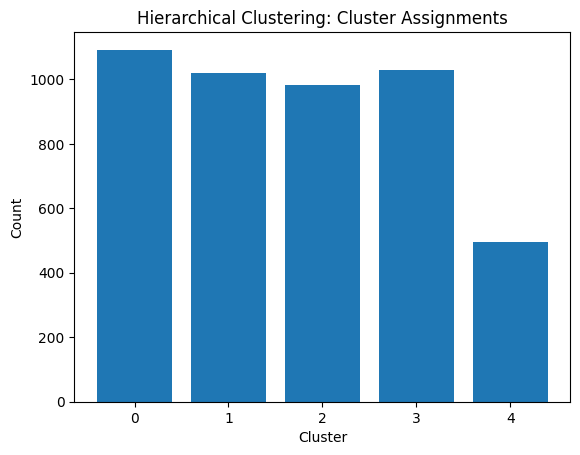

In [12]:
import matplotlib.pyplot as plt

# Train a hierarchical clustering model
K = 5  # Replace with the desired number of clusters
hierarchical_clusterer = BisectingKMeans(featuresCol="scaled_features", k=K, seed=42)
hierarchical_model = hierarchical_clusterer.fit(features)

# Assign cluster labels to the data points
predictions_hierarchical = hierarchical_model.transform(features)

# Extract the cluster assignments from the hierarchical clustering model's predictions
hierarchical_df = predictions_hierarchical.select("scaled_features", "prediction").toPandas()
cluster_assignments_hierarchical = hierarchical_df["prediction"]

# Count the number of data points in each cluster
cluster_counts_hierarchical = cluster_assignments_hierarchical.value_counts()

# Create a bar plot of cluster assignments for hierarchical clustering
plt.bar(cluster_counts_hierarchical.index, cluster_counts_hierarchical.values)
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.title("Hierarchical Clustering: Cluster Assignments")
plt.show()
